In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.reconstruction import DAGMM
from src.trainer.ids import DAGMMIDSTrainer, plot_metrics
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2017Dataset
from src.bootstrap import store_results

In [2]:
# Setup base folder structure
dataset_path = "../../data/IDS2017/ids2017.csv"
export_path = "dagmm_experiments"
if not os.path.exists(export_path):
    os.mkdir(export_path)

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200

# DAGMM-specific arguments
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

print("arguments set")

arguments set


In [ ]:
dataset = IDS2017Dataset(path=dataset_path)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded")

## DAGMM Training

In [4]:
dagmm_model = DAGMM(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_mixtures=n_mixtures,
    latent_dim=latent_dim,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    reg_covar=reg_covar,
    n_layers=n_layers,
    compression_factor=compression_factor,
    ae_act_fn="relu",
    gmm_act_fn="relu"
)
dagmm_trainer = DAGMMIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    device=device,
    model=dagmm_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_fname=os.path.join(export_path, "dagmm"),
    run_test_validation=True
)
print("DAGMM model and trainer ready")

DAGMM model and trainer ready


  0%|          | 0/1110 [00:00<?, ?it/s]

Started training


100%|██████████| 1110/1110 [00:29<00:00, 37.20it/s, epoch=200, loss=2.649]


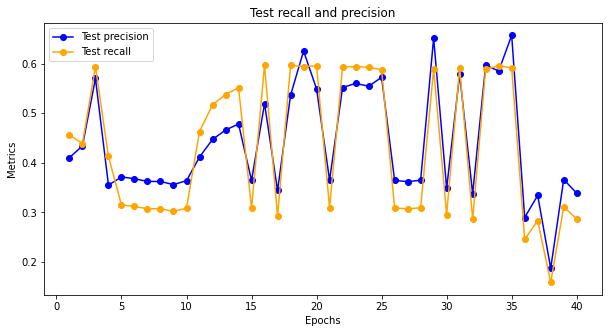

In [5]:
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
dagmm_trainer.train(train_ldr)
plot_metrics(dagmm_trainer["test_precision"], dagmm_trainer["test_recall"], os.path.join(export_path, "dagmm.png"))

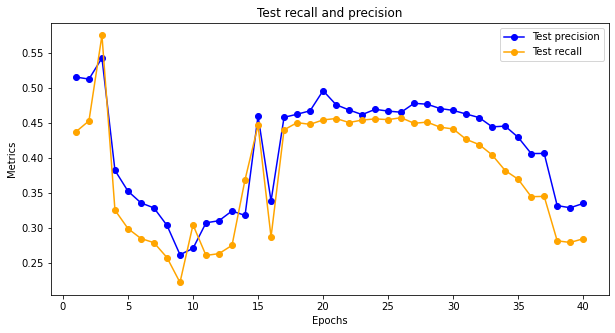

In [9]:
plot_metrics(dagmm_trainer["test_precision"], dagmm_trainer["test_recall"], os.path.join(export_path, "dagmm.png"))

In [14]:
tmp = dagmm_trainer.metric_values['test_precision']
np.argmax(tmp), np.max(tmp)


171

In [15]:
best_epoch = np.argmax(dagmm_trainer.metric_values['test_precision']) * 5 + 1
dagmm_best = "05-03-2022_12-32-25/dagmm_epoch={}.pt".format(best_epoch)
dagmm_trainer, dagmm_model = DAGMMIDSTrainer.load_from_file(dagmm_best, dagmm_trainer, dagmm_model)
dagmm_trainer.n_epochs = dagmm_best_epoch
y_test_true, test_scores, test_labels = dagmm_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=dagmm_best_epoch, **dagmm_model.get_params()),
    model_name="DAGMM",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

{'Precision': 0.6453111722654027,
 'Recall': 0.5937562203775534,
 'F1-Score': 0.618461150518102,
 'AUPR': 0.6075623239164047,
 'AUROC': 0.7788896876012711,
 'Thresh_star': 12.132783889770508,
 'Quantile_star': 69.75838492145886}

In [16]:
dagmm_misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
dagmm_misclf_df = dagmm_misclf_df.sort_values("Misclassified ratio", ascending=False)
dagmm_misclf_df.to_csv(export_path + "/dagmm_misclassifications.csv")
dagmm_misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
SSH-Patator,5897,5855,0.992878
DDoS,128027,106668,0.833168
FTP-Patator,7938,4652,0.586042
DoS,252658,103681,0.410361
Bot,1966,806,0.409969
Infiltration,36,13,0.361111
Heartbleed,11,2,0.181818
Web Attack,2180,356,0.163303
BENIGN,1136374,181988,0.160148
PortScan,158930,4506,0.028352


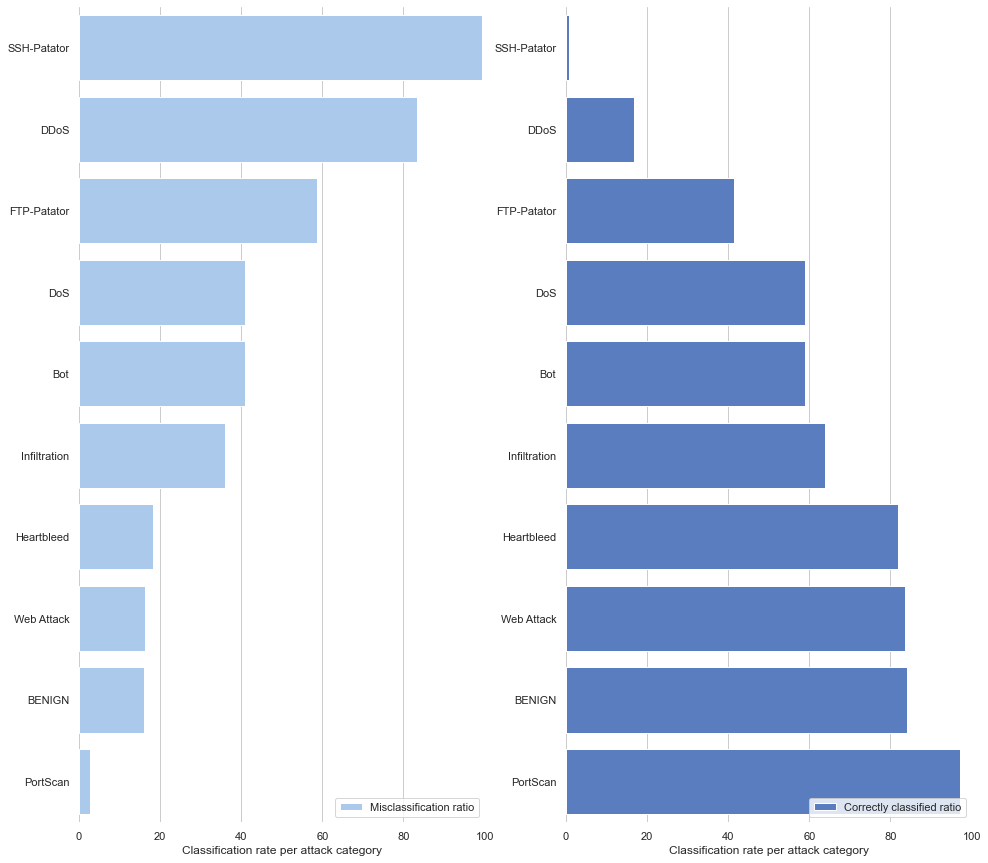

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axs = plt.subplots(figsize=(16, 15), ncols=2)

# Plot misclassification rates
sns.set_color_codes("pastel")
sns.barplot(
    x=dagmm_misclf_df["Misclassified ratio"] * 100,
    y=dagmm_misclf_df.index,
    data=dagmm_misclf_df,
    label="Misclassification ratio",
    color="b",
    ax=axs[0]
)

# Plot correct classification rate
sns.set_color_codes("muted")
sns.barplot(
    x=(1-dagmm_misclf_df["Misclassified ratio"]) * 100,
    y=dagmm_misclf_df.index,
    data=dagmm_misclf_df,
    label="Correctly classified ratio",
    color="b",
    ax=axs[1]
)

# Add a legend and informative axis label
for ax in axs:
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 100), ylabel="", xlabel="Classification rate per attack category")
sns.despine(left=True, bottom=True)